In [11]:
# imports
import pandas as pd
import glob
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from functools import reduce
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import (
    mean_squared_error, r2_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, f_classif
import numpy as np
from sklearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import List, Dict

# Prediction - LOGISTIC REGRESSION WITH ELASTIC NET
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# declarations
# --- 1. Define modalities ---
tupsVarNames = [
    ("bodybattery", 'bodyBattery'),
    ('wellness', 'steps'),
    ('stresslevels','stressScore'),
    ('heartratereadings','beatsPerMinute')
]

# columns to keep (captured data-streams from mongoDB)
capturedData = [ 
    'timestamp', 'patientid', 'beatsPerMinute',
    'bodyBattery', 'activityType', 'steps',
       'stressScore', 'startTime', 'elapsedTime'
]
# patients to include in analysis
spats_csv = r"C:\Users\n.melanitis\Documents\GitHub\AllDayMetrics\Data-28-05-25\D32_corrected_patient_list_with_audit(in).xlsx"
cdata_csv =r"C:\Users\n.melanitis\Documents\GitHub\AllDayMetrics\Data-28-05-25\harmonized_prospective_UK_GR_NL_long_2025_06_13.csv"

# Target for feature selection- column name in clinical data
targetn = 'DOC_FLARE'

# Visit for target- for now this will be T0
visit = 'T0'

# Lit-features- FLAG if True i extract min max 1st and 2nd order diffs (features from lit)
litFLAG = False
if litFLAG:
    extraF = {
            "minimum": None,
            "maximum": None,
            "mean_change": None,
            "mean_abs_change": None,
            "change_quantiles": [
                {"ql": 0.0, "qh": 0.5, "isabs": True, "f_agg": "mean"}  # approximates 2nd-order diff
                ]
        #add the other selected features, extract for all modalities
        }

# fullFLAG- when full FLAG is ON, do full feature extraction and no feature selection
# This makes sense with tsfresh built in select_features: its independent hypothesis testing
# with multiple comparisons correction
fullFLAG = False


# functions
def readParts(name, ids_to_match, capturedData):
    # Pattern to match files like name_part0.parquet, name_part1.parquet, etc.
    pattern = f"{name}_part*.parquet"
    files = sorted(glob.glob(pattern))
    
    # Normalize capturedData column list
    keep_columns = set(capturedData)

    if not files:
        raise FileNotFoundError(f"No files matching pattern {pattern}")
    
    # Read and concatenate all matching parquet files
    dfs = []
    for f in files:
        df =pd.read_parquet(f)
        df = df[df['patientid'].isin(ids_to_match)]
        # Keep only columns that are in capturedData
        cols_to_keep = [col for col in df.columns if col in keep_columns]
        df = df[cols_to_keep]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# --- 4. Filter step rate and compute daily steps from wellness raw data ---
def filterStepRate(welnessdf, activity='WALKING', rate=150):
    verbose = True
    # Filter for activityType
    act = welnessdf[welnessdf['activityType'] == activity].copy()

    # Convert startTime to datetime
    act['startTime'] = pd.to_datetime(act['startTime'], format='%Y-%m-%d %H:%M:%S')

    # Compute step rate (steps per minute)
    act['stepRate'] = act['steps'] / act['elapsedTime'] * 60

    # Filter out records with unrealistic step rate
    act = act[act['stepRate'] < rate]

    # Extract date from timestamp and compute daily steps
    act['date'] = act['startTime'].dt.date
    stepsDay = act.groupby('date')['steps'].sum()

    if verbose:
        for date, steps in stepsDay.items():
            print(f"Date: {date}, Steps per day: {steps}")

    return stepsDay

# --- 5. Preprocess hourly step counts for TSFRESH ---
def prepare_hourly_steps(df, rate=150):
    walking = df[(df['modality'] == 'steps') & (df['activityType'] == 'WALKING')].copy()
    walking['startTime'] = pd.to_datetime(walking['startTime'])

    # drop duplicate entries
    walking.drop_duplicates(subset=['patientid', 'startTime'], inplace=True)

    # Compute step rate and apply filter
    walking['stepRate'] = walking['steps'] / walking['elapsedTime'] * 60
    walking = walking[walking['stepRate'] < rate]

    # Aggregate steps to hourly bins
    walking['hour'] = walking['startTime'].dt.floor('H')
    hourly_steps = (
        walking.groupby(['patientid', 'hour'])['steps']
        .sum()
        .reset_index()
        .rename(columns={'patientid': 'id', 'hour': 'time', 'steps': 'value'})
    )
    return hourly_steps
# --- 6. Preprocess daily step counts for TSFRESH ---
def prepare_daily_steps(df, rate=150):
    walking = df[(df['modality'] == 'steps') & (df['activityType'] == 'WALKING')].copy()
    walking['startTime'] = pd.to_datetime(walking['startTime'])

    # drop duplicate entries
    walking.drop_duplicates(subset=['patientid', 'startTime'], inplace=True)

    # Compute step rate and apply filter
    walking['stepRate'] = walking['steps'] / walking['elapsedTime'] * 60
    walking = walking[walking['stepRate'] < rate]

    # Aggregate steps to daily bins
    walking['date'] = walking['startTime'].dt.floor('D')
    daily_steps = (
        walking.groupby(['patientid', 'date'])['steps']
        .sum()
        .reset_index()
        .rename(columns={'patientid': 'id', 'date': 'time', 'steps': 'value'})
    )
    return daily_steps

# --- 7. Preprocess daily walking time for TSFRESH ---
def prepare_daily_walking_time(df, rate=150):
    walking = df[(df['modality'] == 'steps') & (df['activityType'] == 'WALKING')].copy()
    walking['startTime'] = pd.to_datetime(walking['startTime'])

    # drop duplicate entries
    walking.drop_duplicates(subset=['patientid', 'startTime'], inplace=True)

    # Filter by step rate
    walking['stepRate'] = walking['steps'] / walking['elapsedTime'] * 60
    walking = walking[walking['stepRate'] < rate]

    # Group by patient and day and sum the elapsed walking time in minutes
    walking['date'] = walking['startTime'].dt.floor('D')
    daily_time = (
        walking.groupby(['patientid', 'date'])['elapsedTime']
        .sum()
        .reset_index()
    )
    daily_time['elapsedTime'] = daily_time['elapsedTime'] / 60  # convert to minutes
    daily_time = daily_time.rename(columns={'patientid': 'id', 'date': 'time', 'elapsedTime': 'value'})
    return daily_time
# --- 8. Preprocess daily sedentary behavior proportion for TSFRESH ---
def prepare_daily_sedentary_proportion(df):
    sedentary = df[(df['modality'] == 'steps') & (df['activityType'] == 'SEDENTARY')].copy()
    sedentary['startTime'] = pd.to_datetime(sedentary['startTime'])

    # drop duplicate entries
    sedentary.drop_duplicates(subset=['patientid', 'startTime'], inplace=True)

    # Each record is 1 minute of sedentary behavior
    sedentary['date'] = sedentary['startTime'].dt.floor('D')
    sedentary_minutes = sedentary.groupby(['patientid', 'date']).size().reset_index(name='sedentary_minutes')

    # Total minutes in a day (assume maximum is 1440), we count total entries per day per patient
    daily_counts = df[(df['modality'] == 'steps')].copy()
    daily_counts['startTime'] = pd.to_datetime(daily_counts['startTime'])
    daily_counts['date'] = daily_counts['startTime'].dt.floor('D')
    total_minutes = daily_counts.groupby(['patientid', 'date']).size().reset_index(name='total_minutes')

    # Merge and compute proportion
    merged = pd.merge(sedentary_minutes, total_minutes, on=['patientid', 'date'], how='inner')
    merged['proportion'] = merged['sedentary_minutes'] / merged['total_minutes']

    result = merged.rename(columns={'patientid': 'id', 'date': 'time', 'proportion': 'value'})[['id', 'time', 'value']]
    return result

def get_fc_parameters(modality):
    if modality in ['steps_summary', 'steps_daily', 'walking_time']:
        return {
            'sum_values': None,
            'mean': None,
            'variance': None,
            'standard_deviation': None,
            'linear_trend': [{"attr": attr} for attr in ['intercept', 'slope', 'rvalue']]
        }
    elif modality in ['steps_hourly']:
            return {
            'mean': None,
            'variance': None,
            'standard_deviation': None,
            'linear_trend': [{"attr": attr} for attr in ['intercept', 'slope', 'rvalue']]
        }
    elif modality in ['physical_activity', 'sedentary_prop']:
        return {
            'mean': None,
            'median': None,
            'variance': None,
            'percentage_of_reoccurring_values_to_all_values': None
        }
    else: #let bdybattery, stresscore, bpm be processed like this
        return {
            'sum_values': None,
            'mean': None,
            'variance': None,
            'standard_deviation': None,
            'linear_trend': [{"attr": attr} for attr in ['intercept', 'slope', 'rvalue']]
        }
def daily_summarize(data, value_col: str, time_col: str = 'timestamp', id_col: str = 'patientid'):
    # Ensure timestamp column is in datetime format
    data[time_col] = pd.to_datetime(data[time_col])

    # Create a new column with hourly time (truncate to the hour)
    data['hour'] = data[time_col].dt.floor('D')

    # Group by patient ID and hour, then compute average
    hourly_avg = data.groupby([id_col, 'hour'])[value_col].mean().reset_index()

    # Rename column to indicate it's an hourly average
    # hourly_avg = hourly_avg.rename(columns={value_col: f'{value_col}_hourly_avg'})
    # hourly_avg = hourly_avg.drop(columns=[time_col])
    hourly_avg = hourly_avg.rename(columns={'hour': time_col})
    
    return hourly_avg

def extract_two_week_features(
    tupsVarNames: list,
    spats_csv: str,
    cdata_csv: str,
    capturedData: str,
    litFLAG=False,
    fullFLAG=False,
    impute_flag=True,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Extracts wearable features over a two-week window per patient, with optional imputation.

    Returns:
    - features: pd.DataFrame of extracted features (index=patientid)
    - sclin: clinical data aligned with patients
    - spat: selected patient registration data
    """
    extraF = {
        "minimum": None,
        "maximum": None,
        "mean_change": None,
        "mean_abs_change": None,
        "change_quantiles": [
            {"ql": 0.0, "qh": 0.5, "isabs": True, "f_agg": "mean"}  # approximates 2nd-order diff
            ]
    #add the other selected features, extract for all modalities
    }
    # Load patient selection file
    rawp = pd.read_excel(spats_csv, header=None)
    rawp = rawp[0].str.split(',', expand=True)
    rawp.columns = rawp.iloc[0]
    rawp = rawp[1:]
    spat = rawp[['patientid', 'final_register_date']].copy()
    spat['final_register_date'] = pd.to_datetime(spat['final_register_date'])
    ids_to_match = rawp['patientid'].astype(str).str.lower()

    # Load wearable data
    parquet_dfs = []
    for collection, feature in tupsVarNames:
        fname = f"Mar29_{collection}"
        df = readParts(fname, ids_to_match, capturedData)
        df['modality'] = feature
        df['collection'] = collection
        parquet_dfs.append(df)
        print(f"Loaded {fname} with shape {df.shape}")

    # Filter data to 2-week window from registration
    for i, df in enumerate(parquet_dfs):
        df = df.merge(spat, on='patientid', how='inner')
        try:
            df = df[
                (df['timestamp'] >= df['final_register_date']) &
                (df['timestamp'] < df['final_register_date'] + pd.Timedelta(weeks=2))
            ]
        except KeyError:
            df = df[
                (df['startTime'] >= df['final_register_date']) &
                (df['startTime'] < df['final_register_date'] + pd.Timedelta(weeks=2))
            ]
        parquet_dfs[i] = df

    # Load and filter clinical data
    rawc = pd.read_csv(cdata_csv)
    study_ids = rawc['Study Subject ID'].astype(str).str.lower()
    sclin = rawc[study_ids.isin(ids_to_match)]

    # Prepare feature-specific DataFrames
    # hourly_steps_df = prepare_hourly_steps(parquet_dfs[1])
    daily_steps_df = prepare_daily_steps(parquet_dfs[1])
    daily_walking_time_df = prepare_daily_walking_time(parquet_dfs[1])
    daily_sedentary_prop_df = prepare_daily_sedentary_proportion(parquet_dfs[1])
    daily_bdb = daily_summarize(parquet_dfs[0], 'bodyBattery')
    daily_stress = daily_summarize(parquet_dfs[2], 'stressScore')
    daily_bpm = daily_summarize(parquet_dfs[3], 'beatsPerMinute')
    mname = [#'steps_hourly', 
             'steps_daily', 'walking_time', 'sedentary_prop', 'other', 'other', 'other']
    efconfig = [
        # ('id', 'time', 'value'),
        ('id', 'time', 'value'),
        ('id', 'time', 'value'),
        ('id', 'time', 'value'),
        ('patientid', 'timestamp', 'bodyBattery'),
        ('patientid', 'timestamp', 'stressScore'),
        ('patientid', 'timestamp', 'beatsPerMinute')
    ]
    data = [
        # hourly_steps_df,
        daily_steps_df,
        daily_walking_time_df,
        daily_sedentary_prop_df,
        daily_bdb,
        daily_stress,
        daily_bpm
    ]

    # Extract tsfresh features
    flist = []
    for mod, cfg, dat in zip(mname, efconfig, data):
        custom_fc_parameters = get_fc_parameters(mod)
        if litFLAG:
            custom_fc_parameters.update(extraF)
        if fullFLAG:
            custom_fc_parameters = ComprehensiveFCParameters()
        if cfg[2] == 'value':
            cfg = (cfg[0], cfg[1], mod)
            dat.rename(columns={'value': mod}, inplace=True)

        extracted = extract_features(
            dat,
            column_id=cfg[0],
            column_sort=cfg[1],
            column_value=cfg[2],
            default_fc_parameters=custom_fc_parameters
        )
        extracted.index.name = 'patientid'
        flist.append(extracted)

    # Merge extracted features
    features = reduce(lambda left, right: left.join(right, how='outer'), flist)

    # Optional imputation
    if impute_flag:
        print("Imputing missing values...")
        imp = SimpleImputer(strategy='mean')
        features.iloc[:, :] = imp.fit_transform(features)

    return features, sclin, spat

def prepare_targets_and_features(sclin: pd.DataFrame,
                                 targetn: str,
                                 features: pd.DataFrame,
                                 visit: str = None):
    """
    Returns aligned (features, targets) for regression or classification.

    Parameters:
    - sclin: clinical DataFrame with ['Study Subject ID', targetn, 'Visit Occurrence', ...]
    - targetn: name of the target column (e.g. 'DOC_FLARE')
    - features: DataFrame indexed by lowercase 'patientid'
    - visit: if filtering by visit is needed when targetn == 'DOC_FLARE'
    
    Returns:
    - valid_features: features aligned to non-null targets
    - valid_targets: Series of non-null targets, indexed to match features
    """
    # Copy and rename
    if targetn in ['HAQw', 'PSS']:
        if targetn == 'HAQw':
            # map values and sum
            haq_map = {
                "Without any difficulty": 0,
                "With some difficulty": 1,
                "With much difficulty": 2,
                "Unable to do": 3,
                0: 0, 1: 1, 2: 2, 3: 3  # in case already numeric
            }
            haq_cols = [
                "HAQ01SQ009",  "HAQ01SQ008"
            ]
            # Map and sum per patientid and visit
            target = sclin[["Study Subject ID", "Visit Occurrence"] + haq_cols].copy()
            for col in haq_cols:
                target[col] = target[col].map(haq_map)
            target[targetn] = target[haq_cols].sum(axis=1)

        elif targetn == 'PSS':
            # map values, invert items 4,5,7,8 and sum
            # PSS: Perceived Stress Scale, items 4,5,7,8 are reverse scored
            pss_map = {
                "0 - Never": 0,
                "1 - Rarely": 1,
                "2 - Sometimes": 2,
                "3 - Often": 3,
                "4 - Very often": 4,
                0: 0, 1: 1, 2: 2, 3: 3, 4: 4  # in case already numeric
            }
            # PSS columns, assuming order is 1-10
            pss_cols = [
                "PSS01PDPID0201", "PSS01PDPID0202", "PSS01PDPID0203", "PSS01PDPID0204", "PSS01PDPID0205",
                "PSS01PDPID0206", "PSS01PDPID0207", "PSS01PDPID0208", "PSS01PDPID0209", "PSS01PDPID0210"
            ]
            reverse_items = ["PSS01PDPID0204", "PSS01PDPID0205", "PSS01PDPID0207", "PSS01PDPID0208"]
            target = sclin[["Study Subject ID", "Visit Occurrence"] + pss_cols].copy()
            for col in pss_cols:
                target[col] = target[col].map(pss_map)
            # Reverse score specified items: new = 4 - old
            for col in reverse_items:
                target[col] = 4 - target[col]
            target[targetn] = target[pss_cols].sum(axis=1)

        # do common steps and return
        if visit is not None:
            target = target[target["Visit Occurrence"] == visit]
        target = target.rename(columns={"Study Subject ID": "patientid"})
        target["patientid"] = target["patientid"].str.lower()
        target = target.set_index("patientid")
        valid_targets = target[targetn].dropna()
        common_idx = valid_targets.index.intersection(features.index)
        valid_targets = valid_targets.loc[common_idx]
        valid_features = features.loc[common_idx]
        return valid_features, valid_targets


    target = sclin[['Study Subject ID', targetn]].copy()
    target = target[sclin['Visit Occurrence'] == visit]
    # map values if needed
    if targetn == 'DOC_FLARE':
        target[targetn] = target[targetn].map({'Yes': 1, 'No': 0})
    elif targetn == 'GRCQ01SQ001':
        # Define mapping
        value_map = {
            'UnchangedB 0': 0,
            'UnchangedΒ\xa00': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '-1': -1,
            '-2': -2,
            '-3': -3,
            '-4': -4
        }
        target[targetn] = target[targetn].map(value_map)
   #at the moment no other mappings needed

    target = target.rename(columns={'Study Subject ID': 'patientid'})
    target['patientid'] = target['patientid'].str.lower()
    target = target.set_index('patientid')

    # keep only non-null targets
    valid_targets = target[target[targetn].notna()][targetn]

    # align with features by index intersection (inner join)
    common_idx = valid_targets.index.intersection(features.index)
    valid_targets = valid_targets.loc[common_idx]
    valid_features = features.loc[common_idx]

    return valid_features, valid_targets

def build_wearable_selector_regressor(n_feats: int):
    rf_base = RandomForestRegressor(
        n_estimators=N_ESTIMATORS_FS,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_features="sqrt"
    )
    
    steps: List[tuple] = [("impute", SimpleImputer())]
    
    if TOP_K_PRESELECT and n_feats > TOP_K_PRESELECT:
        steps.append(("preselect", SelectKBest(f_regression, k=TOP_K_PRESELECT)))
    
    steps.append((
        "rfecv",
        RFECV(
            estimator=rf_base,
            step=RFECV_STEP,
            cv=KFold(n_splits=INNER_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
            scoring="neg_mean_squared_error",
            min_features_to_select=MIN_FEATURES_KEEP,
            n_jobs=-1
        )
    ))
    
    return ImbPipeline(steps)

def make_rf_pipeline_regress() -> ImbPipeline:
    steps: List[tuple] = [("impute", SimpleImputer())]
    if USE_SMOTE:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE,
                                                  n_jobs=-1, max_features=MAX_FEATURES)))
    return ImbPipeline(steps)


def run_rfecv_modeling(valid_features: pd.DataFrame,
                       valid_targets: pd.Series,
                       is_regression: bool,
                       build_selector_fn,
                       make_rf_pipeline_fn,
                       N_SPLITS=5,
                       RANDOM_STATE=42,
                       USE_SMOTE=False):
    """
    Runs RFECV feature selection and cross-validated modeling pipeline.

    Parameters:
    - valid_features: DataFrame of input features (index: patientid)
    - valid_targets: Series of target values (index: patientid)
    - is_regression: True for regression, False for classification
    - build_selector_fn: function that returns a RFECV selector
    - make_rf_pipeline_fn: function that returns a modeling pipeline (RF + optional SMOTE etc.)
    - N_SPLITS: number of folds for CV
    - RANDOM_STATE: seed for reproducibility
    - USE_SMOTE: whether pipeline includes SMOTE (for classification)

    Returns:
    - metrics (dict), selector, selected feature names
    """

    X = valid_features
    y = valid_targets

    # --- Feature selection ---
    sel = build_selector_fn(X.shape[1])
    sel.fit(X, y, rfecv__groups=X.index)
    wear_keep = [c for c, k in zip(X.columns, sel.named_steps["rfecv"].support_) if k]
    Xs = X[wear_keep]

    # --- CV setup ---
    if is_regression:
        cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    else:
        cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    pipe = make_rf_pipeline_fn()
    metrics, cms, imps = defaultdict(list), [], []

    # --- Cross-validation ---
    for fold, (tr, te) in enumerate(cv.split(Xs, y), 1):
        print(f"Fold {fold}/{N_SPLITS} train size: {len(tr)}")
        if not is_regression:
            print("    Class balance:", y.iloc[tr].value_counts().to_dict())
        
        pipe.fit(Xs.iloc[tr], y.iloc[tr])

        if USE_SMOTE and not is_regression:
            print("    SMOTE strategy:", pipe.named_steps["smote"].sampling_strategy_)

        y_pred = pipe.predict(Xs.iloc[te])

        if is_regression:
            metrics["RMSE"].append(np.sqrt(mean_squared_error(y.iloc[te], y_pred)))
            metrics["R2"].append(r2_score(y.iloc[te], y_pred))
        else:
            metrics["Balanced Accuracy"].append(balanced_accuracy_score(y.iloc[te], y_pred))
            metrics["Precision"].append(precision_score(y.iloc[te], y_pred, average="macro", zero_division=0))
            metrics["Recall"].append(recall_score(y.iloc[te], y_pred, average="macro", zero_division=0))
            metrics["F1"].append(f1_score(y.iloc[te], y_pred, average="macro", zero_division=0))
            cms.append(confusion_matrix(y.iloc[te], y_pred))

        imps.append(pipe.named_steps["clf"].feature_importances_)

    # --- Print metrics summary ---
    print("\n=== {}-fold CV (mean ± SD) ===".format(N_SPLITS))
    for m, v in metrics.items():
        print(f"{m:>18}: {np.mean(v):.3f} ± {np.std(v):.3f}")

    # --- Confusion matrix ---
    if not is_regression:
        cm = np.sum(cms, axis=0)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Aggregated Confusion Matrix ({}‑fold CV)".format(N_SPLITS))
        plt.tight_layout()
        plt.show()

    # --- Return results ---
    avg_importance = pd.Series(np.mean(np.vstack(imps), axis=0), index=Xs.columns).sort_values(ascending=False)
    return metrics, sel, wear_keep, avg_importance

def build_wearable_selector(n_feats: int):
    rf_base = RandomForestClassifier(n_estimators=N_ESTIMATORS_FS, random_state=RANDOM_STATE,
                                     class_weight="balanced", n_jobs=-1, max_features="sqrt")
    steps: List[tuple] = [("impute", SimpleImputer())]
    if TOP_K_PRESELECT and n_feats > TOP_K_PRESELECT:
        steps.append(("preselect", SelectKBest(f_classif, k=TOP_K_PRESELECT)))
    steps.append(("rfecv", RFECV(rf_base, step=RFECV_STEP, cv=GroupKFold(INNER_CV_FOLDS),
                                  # i dont need groupkFold bcz i dont have rows from the same patient
                                   scoring="balanced_accuracy", min_features_to_select=MIN_FEATURES_KEEP, n_jobs=-1)))
    return ImbPipeline(steps)

# ---------------- MODEL PIPELINE ------------------------------------------------------

def make_rf_pipeline() -> ImbPipeline:
    steps: List[tuple] = [("impute", SimpleImputer())]
    if USE_SMOTE:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE,
                                                 class_weight="balanced", n_jobs=-1, max_features=MAX_FEATURES)))
    return ImbPipeline(steps)


# ELASTIC NET REGRESSION
def run_elastic_logr(valid_features: pd.DataFrame,
                     valid_targets: pd.Series,
                     n_splits: int = 5,
                     random_state: int = 42):
    """
    Runs Elastic Net Logistic Regression with cross-validation.

    Parameters:
    - valid_features: pd.DataFrame of shape (n_samples, n_features)
    - valid_targets: pd.Series of binary labels
    - n_splits: number of CV folds
    - random_state: random seed

    Returns:
    - metrics: dict of CV metrics
    - final_model: trained logistic regression model
    """

    # --- Pipeline ---
    pipe = Pipeline([
        ("impute", SimpleImputer()),  # mean imputation
        ("scale", StandardScaler()),  # scaling is required for ElasticNet
        ("clf", LogisticRegressionCV(
            Cs=10,
            cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state),
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[.1, .5, .9],
            scoring='balanced_accuracy',
            max_iter=5000,
            n_jobs=-1,
            random_state=random_state
        ))
    ])

    # --- Cross-validation ---
    X = valid_features
    y = valid_targets
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics = defaultdict(list)
    cms = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        print(f"Fold {fold}/{n_splits} - Class balance:", y.iloc[train_idx].value_counts().to_dict())
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = pipe.predict(X.iloc[test_idx])

        metrics["Balanced Accuracy"].append(balanced_accuracy_score(y.iloc[test_idx], y_pred))
        metrics["Precision"].append(precision_score(y.iloc[test_idx], y_pred, average="macro", zero_division=0))
        metrics["Recall"].append(recall_score(y.iloc[test_idx], y_pred, average="macro", zero_division=0))
        metrics["F1"].append(f1_score(y.iloc[test_idx], y_pred, average="macro", zero_division=0))
        cms.append(confusion_matrix(y.iloc[test_idx], y_pred))

    # --- Summary ---
    print("\n=== Elastic Net Logistic Regression: {}-fold CV (mean ± SD) ===".format(n_splits))
    for m, v in metrics.items():
        print(f"{m:>18}: {np.mean(v):.3f} ± {np.std(v):.3f}")

    # --- Confusion Matrix ---
    cm = sum(cms)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (Elastic Net LR, {}-fold CV)".format(n_splits))
    plt.tight_layout()
    plt.show()

    # --- Final model trained on all data ---
    pipe.fit(X, y)
    return metrics, pipe


In [3]:
# stat test for lit-sel features
# Extract literature selected features
ffeatures, ssclin, sspat = extract_two_week_features(
    tupsVarNames,
    spats_csv,
    cdata_csv,
    capturedData,
    litFLAG=True,
    fullFLAG=False,
    impute_flag=True,
)
# valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
#                                                                targetn='DOC_FLARE',
#                                                                features=ffeatures,
#                                                                visit='T0' )

Loaded Mar29_bodybattery with shape (25449068, 5)
Loaded Mar29_wellness with shape (21430352, 7)
Loaded Mar29_stresslevels with shape (25689029, 5)
Loaded Mar29_heartratereadings with shape (27179359, 5)


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s]

Imputing missing values...


In [ ]:
# now using the ffeatures = literature selected features
# for all targets get valid features and targets and select features
# a loop for all the targets
outnamel = ['MDA', 'DAPSA','PASDAS','HAQ', 'Pain','Fatigue',
            'Functional', 'Sleep', 'Stiff','GRCQ', 'PSS','HAQw','FLARE']
colnamel = [
    'MDA_Score',
    'DAPSA_Score',
    'PASDAS',
    'Overall HAQ Score',
    'PSAID01PSAID01SQ1',
    'PSAID03PSAID03SQ1',
    'PSAID05PSAID05SQ1',
    'PSAID07PSAID07SQ1',
    'PAT_STIF_H',
    'GRCQ01SQ001',
	'PSS',
	'HAQw',
    'DOC_FLARE'
]
is_regressionl = [False, True, True, True, True, True, True, True, True, True, True, True, False]
for (outname, testregrn, is_regression) in zip(outnamel, colnamel, is_regressionl):
    print(f"\nProcessing target: {outname}")
    valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn=testregrn,
                                                               features=ffeatures,
                                                               visit= visit)
    
    # Select relevant features
    if is_regression:
        print(f"Selecting features for regression target: {testregrn}")
        selected_features = select_features(valid_featuresT, valid_targetsT, ml_task="regression")
    else:
        print(f"Selecting features for classification target: {testregrn}")
        selected_features = select_features(valid_featuresT, valid_targetsT, ml_task="classification")
    print(f"Selected features for {outname}: {selected_features.columns} features")


Processing target: MDA
Selecting features for classification target: MDA_Score
Selected features for MDA: Index([], dtype='object') features

Processing target: DAPSA
Selecting features for regression target: DAPSA_Score
Selected features for DAPSA: Index([], dtype='object') features

Processing target: PASDAS
Selecting features for regression target: PASDAS
Selected features for PASDAS: Index([], dtype='object') features

Processing target: HAQ
Selecting features for regression target: Overall HAQ Score
Selected features for HAQ: Index([], dtype='object') features

Processing target: Pain
Selecting features for regression target: PSAID01PSAID01SQ1
Selected features for Pain: Index([], dtype='object') features

Processing target: Fatigue
Selecting features for regression target: PSAID03PSAID03SQ1
Selected features for Fatigue: Index([], dtype='object') features

Processing target: Functional
Selecting features for regression target: PSAID05PSAID05SQ1
Selected features for Functional: 

In [19]:
# I am adding this so that I may report some numbers from stat tests
from tsfresh.feature_selection.relevance import calculate_relevance_table

# valid_features: DataFrame with extracted features
# valid_targets: target variable (Series)
valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn='DOC_FLARE',
                                                               features=ffeatures,
                                                               visit= visit)

# Step 1: Compute relevance table
relevance_table = calculate_relevance_table(valid_featuresT, valid_targetsT, ml_task='classification')

# Step 2: Filter features if needed (same logic as select_features)
selected_features = relevance_table[relevance_table.relevant]

# Optional: retrieve the filtered feature matrix
filtered_features = valid_featuresT[selected_features.feature]

# Now you have:
# - relevance_table: with p-values and test statistics
# - selected_features: names of features deemed relevant
# - filtered_features: DataFrame with only relevant features



In [27]:
print(f"Relevance table for:\n", relevance_table[['feature', 'p_value']].sort_values(by='p_value'))
relevance_table.to_csv(f"relevance_table.csv", index=False)

Relevance table for:
                                                                                  feature  \
feature                                                                                    
bodyBattery__linear_trend__attr_"intercept"  bodyBattery__linear_trend__attr_"intercept"   
bodyBattery__minimum                                                bodyBattery__minimum   
bodyBattery__mean                                                      bodyBattery__mean   
beatsPerMinute__minimum                                          beatsPerMinute__minimum   
beatsPerMinute__mean                                                beatsPerMinute__mean   
...                                                                                  ...   
walking_time__sum_values                                        walking_time__sum_values   
sedentary_prop__mean_abs_change                          sedentary_prop__mean_abs_change   
steps_daily__mean                                         

In [ ]:
# Statistical test- full tsfresh feature extraction
# stat test for lit-sel features
# Extract literature selected features
full, ssclin, sspat = extract_two_week_features(
    tupsVarNames,
    spats_csv,
    cdata_csv,
    capturedData,
    litFLAG=False,
    fullFLAG=True,
    impute_flag=False,
)
#drop columns with all NaNs
full = full.dropna(axis=1, how='all')
# impute missing values with mean
import numpy as np
full.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(strategy='mean')
full.iloc[:, :] = imp.fit_transform(full)

Loaded Mar29_bodybattery with shape (25449068, 5)
Loaded Mar29_wellness with shape (21430352, 7)
Loaded Mar29_stresslevels with shape (25689029, 5)
Loaded Mar29_heartratereadings with shape (27179359, 5)


Feature Extraction: 100%|██████████| 26/26 [00:03<00:00,  6.60it/s]


In [ ]:
# now using the full = full features extracted with tsfresh
# for all targets get valid features and targets and select features
# a loop for all the targets
outnamel = ['MDA', 'DAPSA','PASDAS','HAQ', 'Pain','Fatigue',
            'Functional', 'Sleep', 'Stiff','GRCQ', 'PSS','HAQw','FLARE']
colnamel = [
    'MDA_Score',
    'DAPSA_Score',
    'PASDAS',
    'Overall HAQ Score',
    'PSAID01PSAID01SQ1',
    'PSAID03PSAID03SQ1',
    'PSAID05PSAID05SQ1',
    'PSAID07PSAID07SQ1',
    'PAT_STIF_H',
    'GRCQ01SQ001',
	'PSS',
	'HAQw',
    'DOC_FLARE'
]
is_regressionl = [False, True, True, True, True, True, 
                  True, True, True, True, True, True, False]
for (outname, testregrn, is_regression) in zip(outnamel, colnamel, is_regressionl):
    print(f"\nProcessing target: {outname}")
    valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn=testregrn,
                                                               features=full,
                                                               visit= visit)
    
    # Select relevant features
    if is_regression:
        print(f"Selecting features for regression target: {testregrn}")
        selected_features = select_features(valid_featuresT, valid_targetsT, ml_task="regression")
    else:
        print(f"Selecting features for classification target: {testregrn}")
        selected_features = select_features(valid_featuresT, valid_targetsT, ml_task="classification")
    print(f"Selected features for {outname}: {selected_features.columns} features")


Processing target: MDA
Selecting features for classification target: MDA_Score
Selected features for MDA: Index([], dtype='object') features

Processing target: DAPSA
Selecting features for regression target: DAPSA_Score
Selected features for DAPSA: Index([], dtype='object') features

Processing target: PASDAS
Selecting features for regression target: PASDAS
Selected features for PASDAS: Index([], dtype='object') features

Processing target: HAQ
Selecting features for regression target: Overall HAQ Score
Selected features for HAQ: Index([], dtype='object') features

Processing target: Pain
Selecting features for regression target: PSAID01PSAID01SQ1
Selected features for Pain: Index([], dtype='object') features

Processing target: Fatigue
Selecting features for regression target: PSAID03PSAID03SQ1
Selected features for Fatigue: Index([], dtype='object') features

Processing target: Functional
Selecting features for regression target: PSAID05PSAID05SQ1
Selected features for Functional: 


Processing target: MDA
Fold 1/5 train size: 52
    Class balance: {0.0: 27, 1.0: 25}
Fold 2/5 train size: 52
    Class balance: {0.0: 27, 1.0: 25}
Fold 3/5 train size: 52
    Class balance: {1.0: 26, 0.0: 26}
Fold 4/5 train size: 52
    Class balance: {1.0: 26, 0.0: 26}
Fold 5/5 train size: 52
    Class balance: {1.0: 26, 0.0: 26}

=== 5-fold CV (mean ± SD) ===
 Balanced Accuracy: 0.595 ± 0.112
         Precision: 0.629 ± 0.145
            Recall: 0.595 ± 0.112
                F1: 0.586 ± 0.107


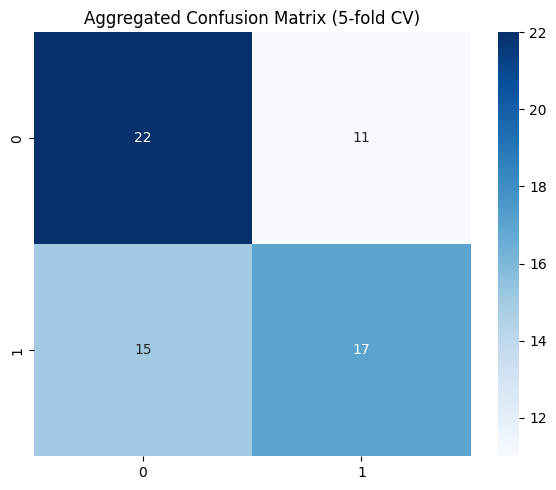

Selected features for MDA: ['steps_daily__variance', 'steps_daily__linear_trend__attr_"intercept"', 'steps_daily__linear_trend__attr_"slope"', 'steps_daily__linear_trend__attr_"rvalue"', 'steps_daily__maximum', 'steps_daily__mean_change', 'steps_daily__change_quantiles__f_agg_"mean"__isabs_True__qh_0.5__ql_0.0', 'walking_time__linear_trend__attr_"intercept"', 'walking_time__linear_trend__attr_"rvalue"', 'walking_time__maximum', 'walking_time__mean_change', 'walking_time__change_quantiles__f_agg_"mean"__isabs_True__qh_0.5__ql_0.0', 'sedentary_prop__mean', 'sedentary_prop__variance', 'sedentary_prop__maximum', 'sedentary_prop__mean_change', 'sedentary_prop__change_quantiles__f_agg_"mean"__isabs_True__qh_0.5__ql_0.0', 'bodyBattery__sum_values', 'bodyBattery__linear_trend__attr_"intercept"', 'bodyBattery__linear_trend__attr_"slope"', 'bodyBattery__linear_trend__attr_"rvalue"', 'bodyBattery__maximum', 'bodyBattery__mean_change', 'bodyBattery__mean_abs_change', 'stressScore__variance', 'stre

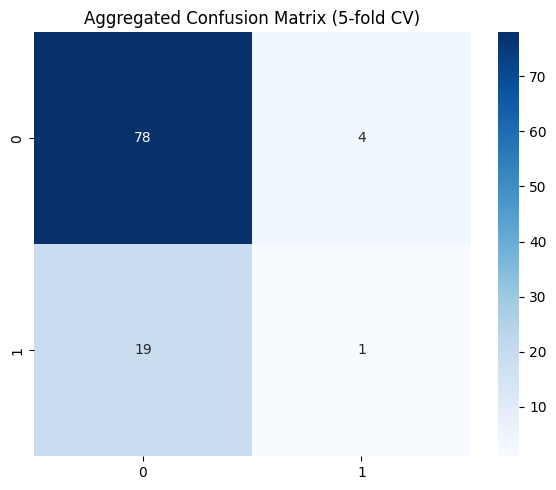

Selected features for DOC_FLARE: ['steps_daily__change_quantiles__f_agg_"mean"__isabs_True__qh_0.5__ql_0.0', 'walking_time__minimum', 'bodyBattery__mean', 'bodyBattery__standard_deviation', 'bodyBattery__minimum']
Importance scores for DOC_FLARE:
bodyBattery__standard_deviation                                            0.233888
bodyBattery__minimum                                                       0.220279
steps_daily__change_quantiles__f_agg_"mean"__isabs_True__qh_0.5__ql_0.0    0.193188
walking_time__minimum                                                      0.180342
bodyBattery__mean                                                          0.172302
dtype: float64


In [10]:
# RFECV feature selection
N_ESTIMATORS = 25 #i have just 100 datapoints
N_ESTIMATORS_FS =25
RANDOM_STATE      = 42
USE_SMOTE         = False
INNER_CV_FOLDS    = 5
RFECV_STEP        = 5
TOP_K_PRESELECT   = 1000 # setting this high essential disables preselection
MIN_FEATURES_KEEP = 5
RUN_RFE_ALWAYS    = False

N_SPLITS       = 5
MAX_FEATURES   = "sqrt"

# Run for MDA, DOC_FLARE, for the other targets (regression) I get worse than
# random results, so I will not run RFECV for them

# outnamel = ['MDA', 'DAPSA','PASDAS','HAQ', 'Pain','Fatigue',
#             'Functional', 'Sleep', 'Stiff','GRCQ', 'PSS','HAQw','FLARE']
# colnamel = [
#     'MDA_Score',
#     'DAPSA_Score',
#     'PASDAS',
#     'Overall HAQ Score',
#     'PSAID01PSAID01SQ1',
#     'PSAID03PSAID03SQ1',
#     'PSAID05PSAID05SQ1',
#     'PSAID07PSAID07SQ1',
#     'PAT_STIF_H',
#     'GRCQ01SQ001',
# 	'PSS',
# 	'HAQw',
#     'DOC_FLARE'
# ]
# is_regressionl = [False, True, True, True, True, True, 
#                   True, True, True, True, True, True, False]

outnamel = ['MDA', 'DOC_FLARE']
colnamel = ['MDA_Score', 'DOC_FLARE']
is_regressionl = [False, False]  

for (outname, testregrn, is_regression) in zip(outnamel, colnamel, is_regressionl):
    print(f"\nProcessing target: {outname}")
    valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn=testregrn,
                                                               features=ffeatures,
                                                               visit= visit)
    
    # Select relevant features
    metrics, selector, selected_features, importance_scores = run_rfecv_modeling(
    valid_features=valid_featuresT,
    valid_targets=valid_targetsT,
    is_regression=is_regression,  
    build_selector_fn=build_wearable_selector if not is_regression else build_wearable_selector_regressor,
    make_rf_pipeline_fn=make_rf_pipeline if not is_regression else make_rf_pipeline_regress,
    USE_SMOTE=False
)

    # Save results or do further processing as needed
    print(f"Selected features for {outname}: {selected_features}")
    print(f"Importance scores for {outname}:\n{importance_scores}")



Processing target: MDA
Fold 1/5 - Class balance: {0.0: 27, 1.0: 25}
Fold 2/5 - Class balance: {0.0: 27, 1.0: 25}
Fold 3/5 - Class balance: {1.0: 26, 0.0: 26}
Fold 4/5 - Class balance: {1.0: 26, 0.0: 26}
Fold 5/5 - Class balance: {1.0: 26, 0.0: 26}

=== Elastic Net Logistic Regression: 5-fold CV (mean ± SD) ===
 Balanced Accuracy: 0.524 ± 0.053
         Precision: 0.424 ± 0.151
            Recall: 0.524 ± 0.053
                F1: 0.456 ± 0.112


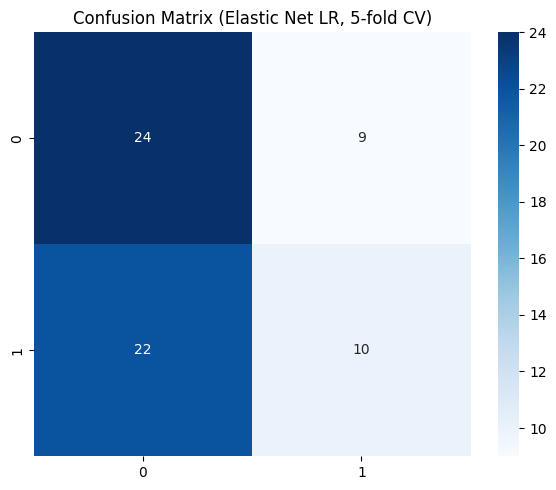

Metrics for MDA:
defaultdict(<class 'list'>, {'Balanced Accuracy': [0.5, 0.6190476190476191, 0.5357142857142857, 0.4642857142857143, 0.5], 'Precision': [0.23076923076923078, 0.6190476190476191, 0.5357142857142857, 0.4642857142857143, 0.2692307692307692], 'Recall': [0.5, 0.6190476190476191, 0.5357142857142857, 0.4642857142857143, 0.5], 'F1': [0.3157894736842105, 0.6153846153846154, 0.5357142857142857, 0.46153846153846156, 0.35]})

=== Selected Features by Elastic Net Logistic Regression ===
                                              feature  coefficient
59                           beatsPerMinute__variance    -2.110631
2                               steps_daily__variance     1.952609
63        beatsPerMinute__linear_trend__attr_"rvalue"    -1.860246
51           stressScore__linear_trend__attr_"rvalue"     1.808040
38            bodyBattery__linear_trend__attr_"slope"     1.706367
22                      walking_time__mean_abs_change    -1.618361
11  steps_daily__change_quantiles__f

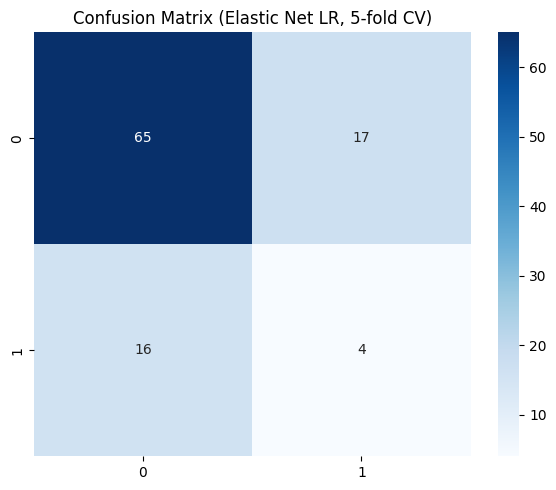

Metrics for DOC_FLARE:
defaultdict(<class 'list'>, {'Balanced Accuracy': [0.3897058823529412, 0.5955882352941176, 0.5, 0.65625, 0.34375], 'Precision': [0.4305555555555556, 0.6710526315789473, 0.4, 0.6333333333333333, 0.36666666666666664], 'Recall': [0.3897058823529412, 0.5955882352941176, 0.5, 0.65625, 0.34375], 'F1': [0.38726790450928383, 0.611111111111111, 0.4444444444444444, 0.6415770609318996, 0.3548387096774194]})

=== Selected Features by Elastic Net Logistic Regression ===
                                              feature  coefficient
11  steps_daily__change_quantiles__f_agg_"mean"__i...    -0.678093
37        bodyBattery__linear_trend__attr_"intercept"    -0.601209
20                              walking_time__maximum     0.443538
64                            beatsPerMinute__minimum     0.393369
31                    sedentary_prop__mean_abs_change    -0.381753
50            stressScore__linear_trend__attr_"slope"    -0.276288
65                            beatsPerMinute__

In [13]:
# Regression with ELASTIC net
outnamel = ['MDA', 'DOC_FLARE']
colnamel = ['MDA_Score', 'DOC_FLARE']
is_regressionl = [False, False]

for (outname, testregrn, is_regression) in zip(outnamel, colnamel, is_regressionl):
    print(f"\nProcessing target: {outname}")
    valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn=testregrn,
                                                               features=ffeatures,
                                                               visit= visit)
    
    # Run Elastic Net Regression
    metrics, final_model = run_elastic_logr(
        valid_features=valid_featuresT,
        valid_targets=valid_targetsT,
        n_splits=5,
        random_state=RANDOM_STATE
    )

    # Print metrics
    print(f"Metrics for {outname}:\n{metrics}")
    # Access fitted logistic regression model
    logr = final_model.named_steps["clf"]

    # Get feature names and coefficients
    feature_names = valid_featuresT.columns
    coefs = logr.coef_[0]  # shape: (1, n_features) for binary

    # Create a DataFrame for inspection
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs
    })

    # Filter non-zero (selected) features
    selected_features_df = coef_df[coef_df["coefficient"] != 0].sort_values(by="coefficient", key=abs, ascending=False)

    # Display
    print("\n=== Selected Features by Elastic Net Logistic Regression ===")
    print(selected_features_df)

In [ ]:
# do a regression model-- NOT in results
# just in case I can report any of these
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

def run_elastic_linr(valid_features: pd.DataFrame,
                     valid_targets: pd.Series,
                     n_splits: int = 5,
                     random_state: int = 42):
    """
    Runs Elastic Net Linear Regression with cross-validation.

    Parameters:
    - valid_features: pd.DataFrame of shape (n_samples, n_features)
    - valid_targets: pd.Series of continuous labels
    - n_splits: number of CV folds
    - random_state: random seed

    Returns:
    - metrics: dict of CV metrics
    - final_model: trained regression pipeline
    """

    # --- Pipeline ---
    pipe = Pipeline([
        ("impute", SimpleImputer()),  # mean imputation
        ("scale", StandardScaler()),  # scaling is required for ElasticNet
        ("reg", ElasticNetCV(
            l1_ratio=[.1, .5, .9],
            cv=KFold(n_splits=n_splits, shuffle=True, random_state=random_state),
            n_alphas=100,
            random_state=random_state,
            max_iter=5000
        ))
    ])

    # --- Cross-validation ---
    X = valid_features
    y = valid_targets
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics = defaultdict(list)

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        print(f"Fold {fold}/{n_splits} - Train size: {len(train_idx)}")
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = pipe.predict(X.iloc[test_idx])

        metrics["RMSE"].append(np.sqrt(mean_squared_error(y.iloc[test_idx], y_pred)))
        metrics["R2"].append(r2_score(y.iloc[test_idx], y_pred))

    # --- Summary ---
    print(f"\n=== Elastic Net Linear Regression: {n_splits}-fold CV (mean ± SD) ===")
    for m, v in metrics.items():
        print(f"{m:>8}: {np.mean(v):.3f} ± {np.std(v):.3f}")

    # --- Final model trained on all data ---
    pipe.fit(X, y)
    return metrics, pipe

outnamel = ['DAPSA','PASDAS','HAQ', 'Pain','Fatigue','Functional', 'Sleep', 'Stiff','GRCQ', 'PSS','HAQw']
colnamel = [
    'DAPSA_Score',
    'PASDAS',
    'Overall HAQ Score',
    'PSAID01PSAID01SQ1',
    'PSAID03PSAID03SQ1',
    'PSAID05PSAID05SQ1',
    'PSAID07PSAID07SQ1',
    'PAT_STIF_H',
    'GRCQ01SQ001',
    'PSS',
    'HAQw'
]
for (outname, testregrn) in zip(outnamel, colnamel):
    print(f"\nProcessing target: {outname}")
    valid_featuresT, valid_targetsT = prepare_targets_and_features(sclin=ssclin,
                                                               targetn=testregrn,
                                                               features=ffeatures,
                                                               visit= visit)
    metrics, final_model = run_elastic_linr(
                            valid_features=valid_featuresT,
                            valid_targets=valid_targetsT,
                            n_splits=5,
                            random_state=42)
    # Access fitted ElasticNet model
    linr = final_model.named_steps["reg"]

    # Get feature names and coefficients
    feature_names = valid_featuresT.columns
    coefs = linr.coef_

    # Create a DataFrame for inspection
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs
    })

    # Filter non-zero (selected) features
    selected_features_df = coef_df[coef_df["coefficient"] != 0].sort_values(by="coefficient", key=abs, ascending=False)

    # Display
    print("\n=== Selected Features by Elastic Net Linear Regression ===")
    print(selected_features_df)

